# Noisy LIF Neuron

We consider the equation of the LIF model, adding a white noise to it. 

\begin{align}
	&\tau_m \dfrac{d V_m}{d t}  = E_l - V_m + I_0 + \sigma\sqrt{\tau_m}\,\eta(t)\\
	&\text{if $V_m > V_{th}$ , then $V_m =V_{reset}$}
\end{align}
with $\eta (t) \sim \mathcal{N}(0,1)$.

We are going to simulate this equation with the Euler method.

In [2]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

plt.rcParams["figure.figsize"] = (15, 7)
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)

title_fontsize = 36
ax_fontsize = 28
label_fontsize = 20

Cm = 100e-12  # in F
gl = 10e-9    # in S
El = -70e-3   # in V
taum = Cm/gl  # in s

In [65]:
def noisy_LIF_neuron(t,dt,I,V0,sigma):
    # Numerical simulation of a noisy LIF neuron (white noise)
    N = int(t/dt)+1
    V = V0*np.ones(N)
    eta = np.random.normal(size=N)
    for i in range(1,N):
        updt_V = -(V[i-1] - El)/taum + I[i]/Cm + sigma*eta[i]/np.sqrt(taum*dt)
        V[i] = V[i-1] + dt*updt_V
        if V[i] > Vth:
            V[i] = Vreset
    return V

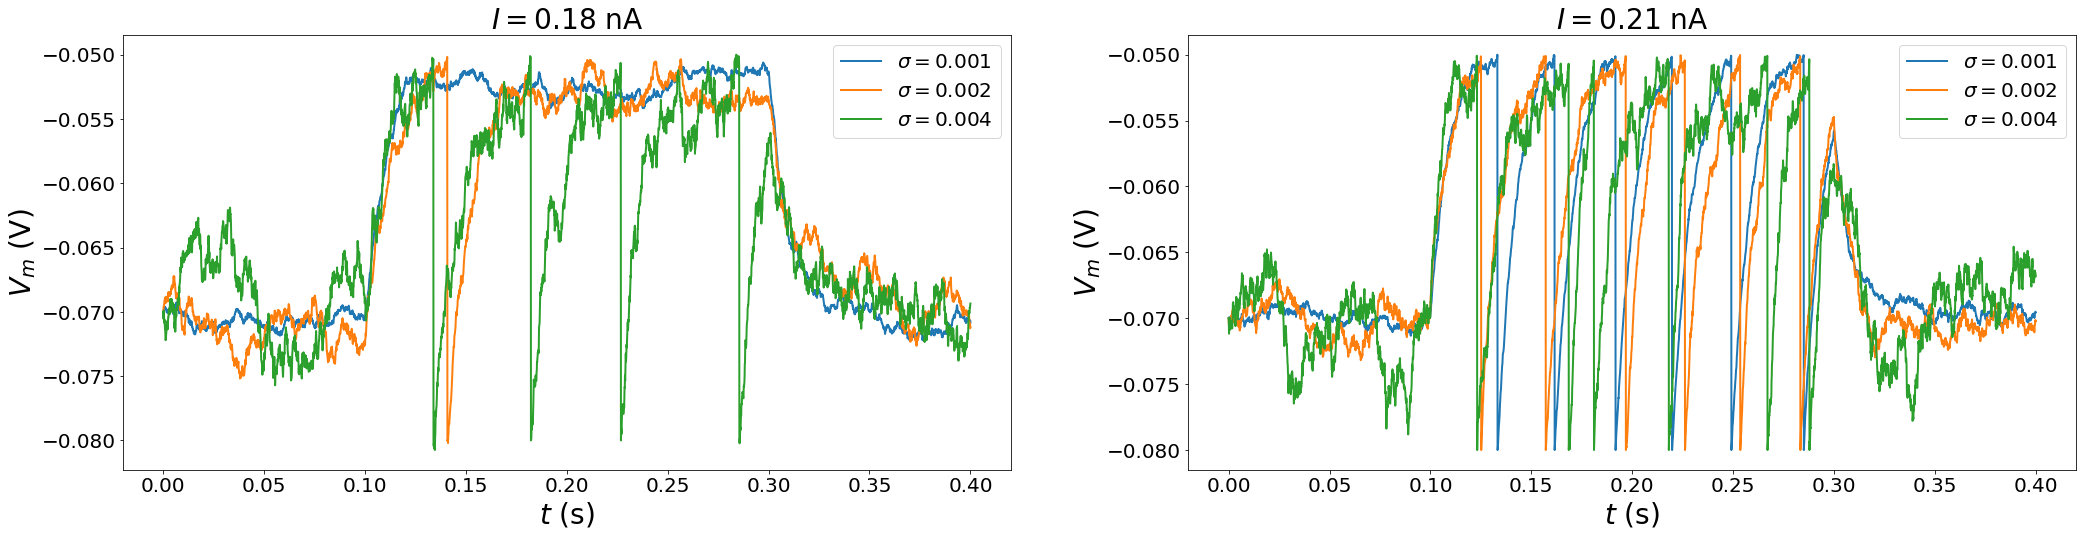

In [66]:
Vth = -50.0e-3    # V
Vreset = -80.0e-3 # V
V0 = -70.0e-3     # V
# with these conditions taum = 10ms and Ith = 200 pA

dt = .0001
t = .4
time_abs = np.linspace(0,t,int(t/dt)+1)

def step_I(I0, time_abs=time_abs, t_min=.1, t_max=.3):
    I = I0*np.ones(int(t/dt)+1)
    I[time_abs<t_min] = 0
    I[time_abs>t_max] = 0
    return I

fig, axes = plt.subplots(1,2,figsize=(35,8))

I0s = [.18e-9, .21e-9]
sigmas = [.001,.002,.004]
for sigma in sigmas:
    I = step_I(I0=I0s[0])
    V = noisy_LIF_neuron(t,dt,I,V0,sigma)
    axes[0].plot(time_abs,V,lw=2,label=r"$\sigma = "+str(sigma)+"$")
    axes[0].set_xlabel(r"$t$ (s)", fontsize=ax_fontsize)
    axes[0].set_ylabel(r"$V_m$ (V)", fontsize=ax_fontsize)
    axes[0].set_title(r"$I = "+str(I0s[0]*1e9)+"$ nA", fontsize=ax_fontsize)
    axes[0].legend(fontsize=label_fontsize)
    
    I = step_I(I0=I0s[1])
    V = noisy_LIF_neuron(t,dt,I,V0,sigma)
    axes[1].plot(time_abs,V,lw=2,label=r"$\sigma = "+str(sigma)+"$")
    axes[1].set_xlabel(r"$t$ (s)", fontsize=ax_fontsize)
    axes[1].set_ylabel(r"$V_m$ (V)", fontsize=ax_fontsize)
    axes[1].set_title(r"$I = "+str(I0s[1]*1e9)+"$ nA", fontsize=ax_fontsize)
    axes[1].legend(fontsize=label_fontsize)
plt.show()

## LIF neuron f-I curve

We are now going to focus on the f-I curve of the neuron. We consider a LIF neuron, with the same parameters as previously.

In [67]:
def noisy_LIF_neuron_FR(t,dt,I,V0,sigma):
    # Numerical simulation of a noisy LIF neuron (white noise) with firing rate computation
    N = int(t/dt)+1
    V = V0*np.ones(N)
    spike_count = 0
    eta = np.random.normal(size=N)
    for i in range(1,N):
        updt_V = -(V[i-1] - El)/taum + I[i]/Cm + sigma*eta[i]/np.sqrt(taum*dt)
        V[i] = V[i-1] + dt*updt_V
        if V[i] > Vth:
            V[i] = Vreset
            spike_count += 1
    return V, spike_count/t

In [69]:
Vth = -50.0e-3
Vreset = -80.0e-3
V0 = El

dt = .0001
t = 3
time_abs = np.linspace(0,t,int(t/dt)+1)

Iapp = np.arange(0,500)*1e-12 # in pA
sigmas = [.001,.002,.004]

FRs = np.zeros((len(sigmas),len(Iapp)))
for k in range(len(sigmas)):
    sigma = sigmas[k]
    for i in range(len(Iapp)):
        I0 = Iapp[i]
        I = I0*np.ones(int(t/dt)+1)
        V, FR = noisy_LIF_neuron_FR(t,dt,I,V0,sigma)
        FRs[k,i] = FR

In [172]:
# from scipy.special import erf
# from scipy.integrate import quad

# def FR_int(x):
#     return np.exp(x**2)*(1+erf(x))

# def th_fI(Is, sigma):
#     sigma_0 = sigma/np.sqrt(taum)
#     mu = El + Is/gl
#     th_FRs = np.zeros(len(Is))
#     for i in range(len(Is)):
#         th_FRs[i] = 1/(taum*np.sqrt(np.pi)*quad(FR_int, (Vreset-mu[i])/sigma_0, (Vth-mu[i])/sigma_0)[0])
#     return th_FRs

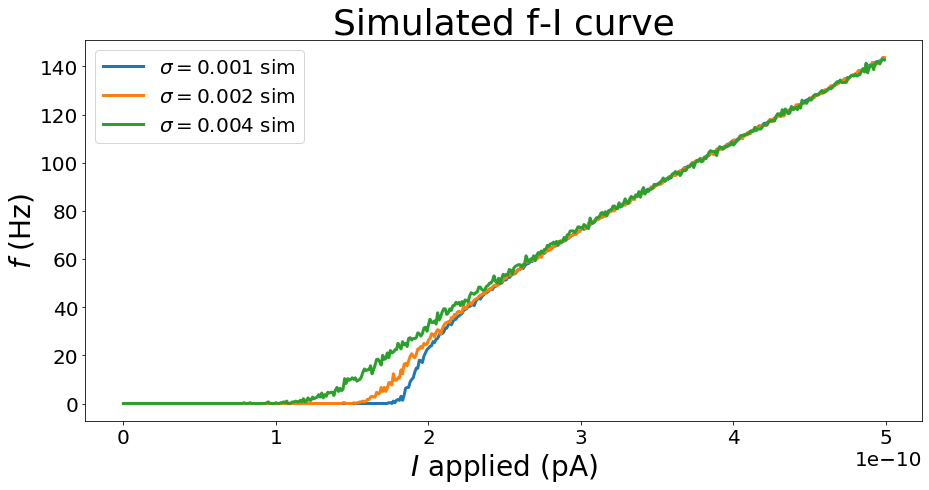

In [174]:
for k in range(len(sigmas)):
    sigma = sigmas[k]
    plt.plot(Iapp,FRs[k],lw=3,label=r"$\sigma = "+str(sigma)+"$ sim")
#     plt.plot(Iapp,th_fI(Iapp,sigma),"--",lw=3,label=r"$\sigma = "+str(sigma)+"$ ana")
    plt.xlabel(r"$I$ applied (pA)", fontsize=ax_fontsize)
    plt.ylabel(r"$f$ (Hz)", fontsize=ax_fontsize)
    plt.title("Simulated f-I curve", fontsize=title_fontsize)
    plt.legend(fontsize=label_fontsize)
plt.show()

## ISI distribution

In [178]:
def noisy_LIF_neuron_spikes(t,dt,I,V0,sigma):
    # Numerical simulation of a noisy LIF neuron (white noise) with firing rate computation
    N = int(t/dt)+1
    V = V0*np.ones(N)
    spikes = []
    eta = np.random.normal(size=N)
    for i in range(1,N):
        updt_V = -(V[i-1] - El)/taum + I/Cm + sigma*eta[i]/np.sqrt(taum*dt)
        V[i] = V[i-1] + dt*updt_V
        if V[i] > Vth:
            V[i] = Vreset
            spikes.append(i*dt)
    return V, spikes

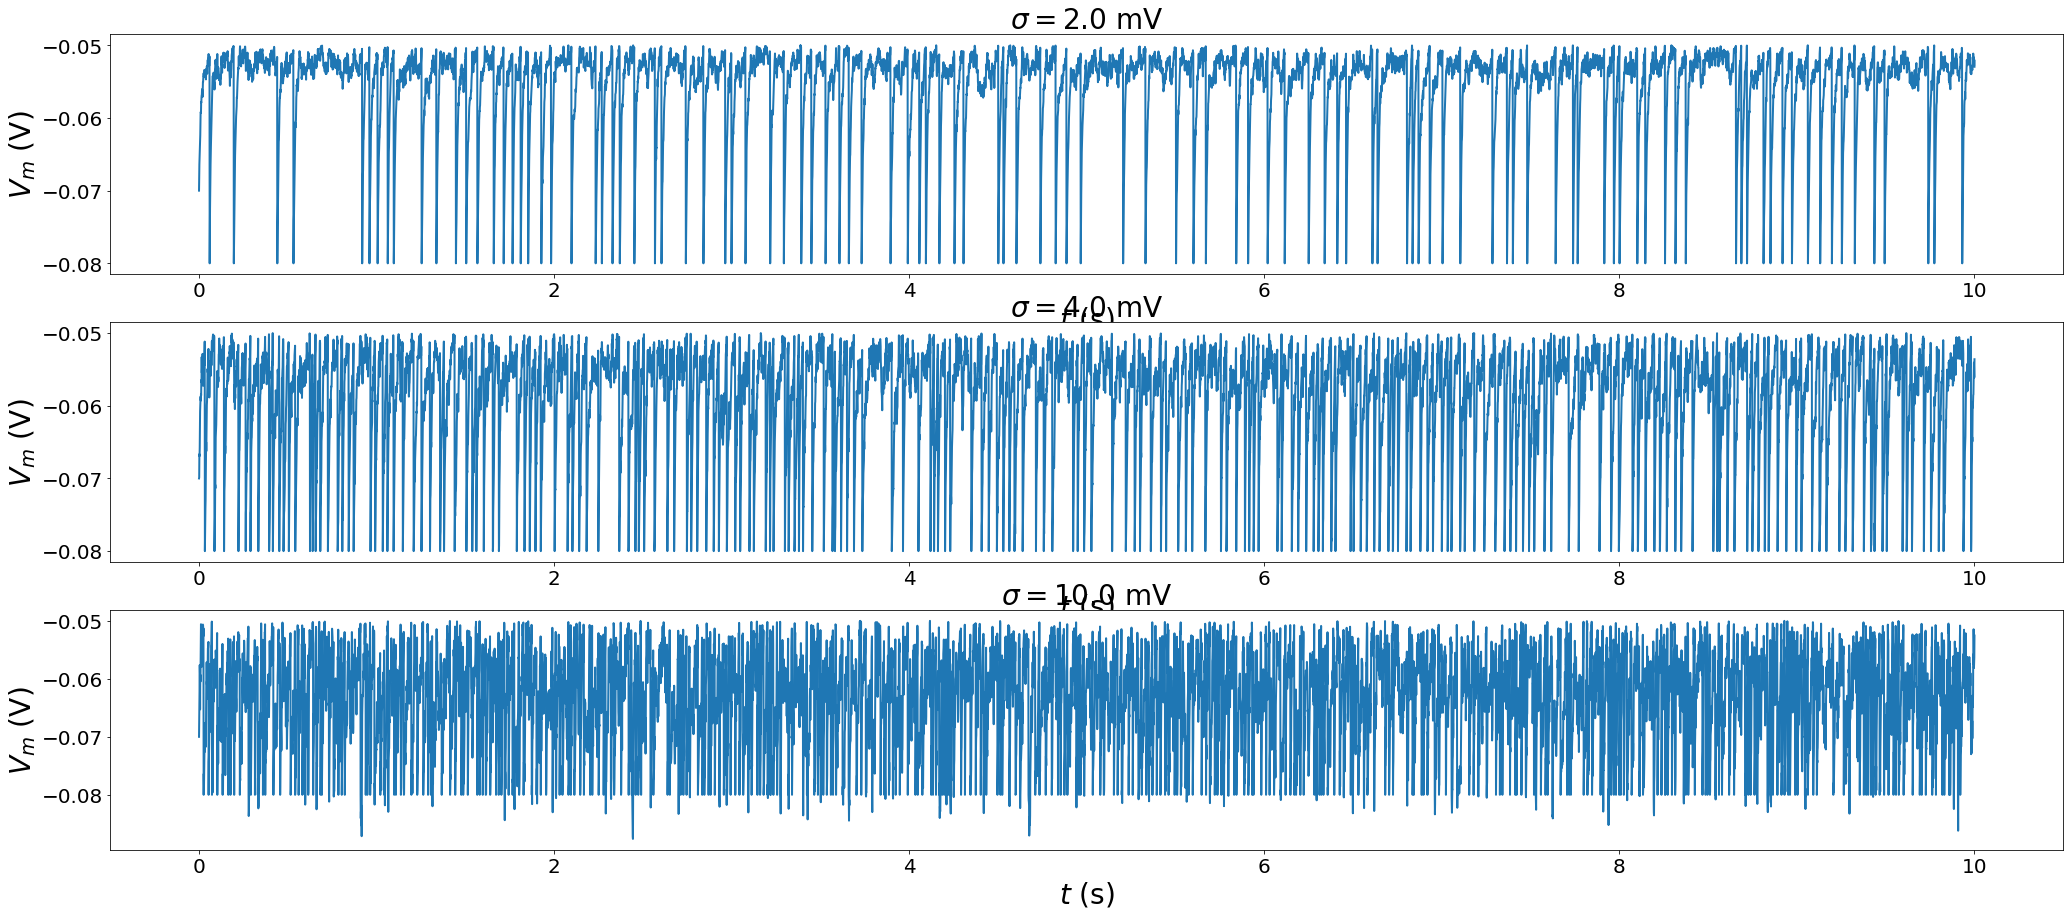

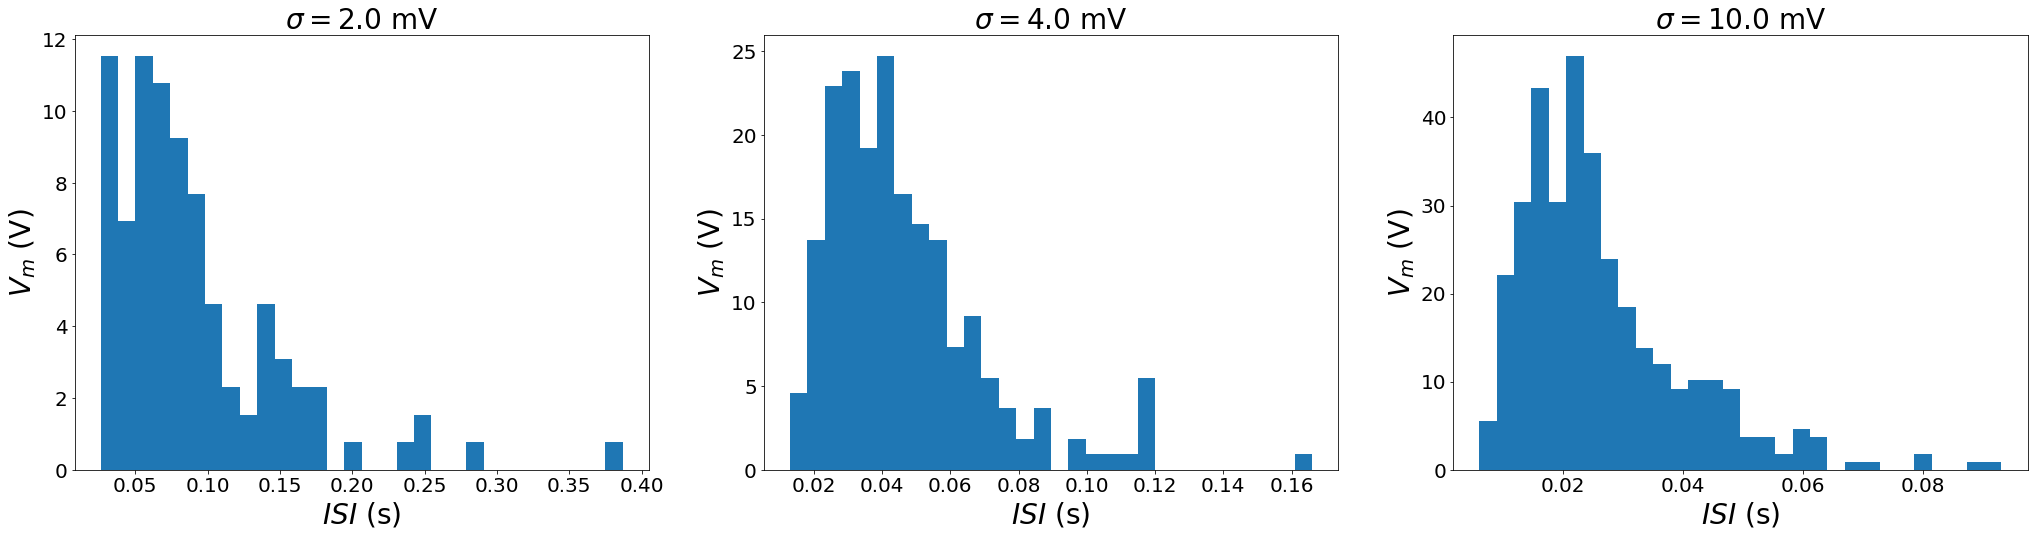

In [183]:
dt = .001
t = 10
time_abs = np.linspace(0,t,int(t/dt)+1)

I = .18e-9
sigmas = [.002,.004,.01]

fig, axes = plt.subplots(len(sigmas),1,figsize=(35,15))
spks = []
for k in range(len(sigmas)):
    sigma = sigmas[k]
    V, spikes = noisy_LIF_neuron_spikes(t,dt,I,V0,sigma)
    spks.append(spikes)
    axes[k].plot(time_abs,V,lw=2)
    axes[k].set_xlabel(r"$t$ (s)", fontsize=ax_fontsize)
    axes[k].set_ylabel(r"$V_m$ (V)", fontsize=ax_fontsize)
    axes[k].set_title(r"$\sigma = "+str(sigma*1000)+"$ mV", fontsize=ax_fontsize)
plt.show()

fig, axes = plt.subplots(1,len(sigmas),figsize=(35,8))
for k in range(len(sigmas)):
    sigma = sigmas[k]
    ISI = np.array(spks[k])
    ISI = ISI[1:]-ISI[:-1]
    axes[k].hist(ISI,bins=30,density=True)
    axes[k].set_xlabel(r"$ISI$ (s)", fontsize=ax_fontsize)
    axes[k].set_ylabel(r"$V_m$ (V)", fontsize=ax_fontsize)
    axes[k].set_title(r"$\sigma = "+str(sigma*1000)+"$ mV", fontsize=ax_fontsize)